# 2A.ml - Séries temporelles - correction

Prédictions sur des séries temporelles.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Une série temporelles

On récupère le nombre de sessions d'un site web.

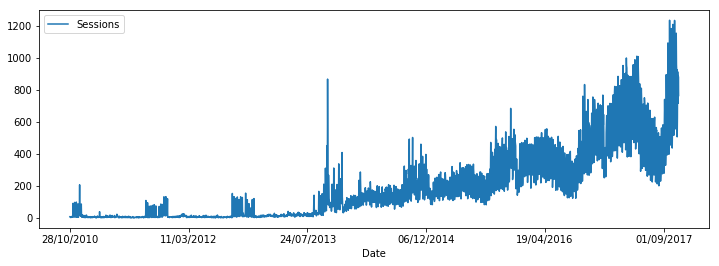

In [3]:
import pandas
data = pandas.read_csv("xavierdupre_sessions.csv", sep="\t")
data.set_index("Date", inplace=True)
data.plot(figsize=(12,4))

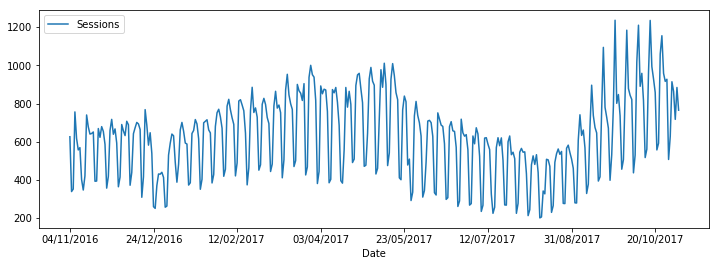

In [4]:
data[-365:].plot(figsize=(12,4))

## Trends

Fonction [detrend](http://www.statsmodels.org/dev/generated/statsmodels.tsa.tsatools.detrend.html#statsmodels.tsa.tsatools.detrend).

In [5]:
from statsmodels.tsa.tsatools import detrend
notrend = detrend(data['Sessions'])
data["notrend"] = notrend
data["trend"] = data['Sessions'] - notrend
data.tail()

,Sessions,notrend,notrend2,logSess,logtrend,trend
Date,,,,,,
30/10/2017,914,367.387637,206.501063,6.818924,-0.246035,546.612363
31/10/2017,863,316.119822,154.853947,6.761573,-0.305603,546.880178
01/11/2017,717,169.852008,8.206533,6.576470,-0.492923,547.147992
02/11/2017,884,336.584193,174.558823,6.785588,-0.286021,547.415807
03/11/2017,765,217.316379,54.910816,6.641182,-0.432643,547.683621


c:\python36_x64\lib\site-packages\pandas\plotting\_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


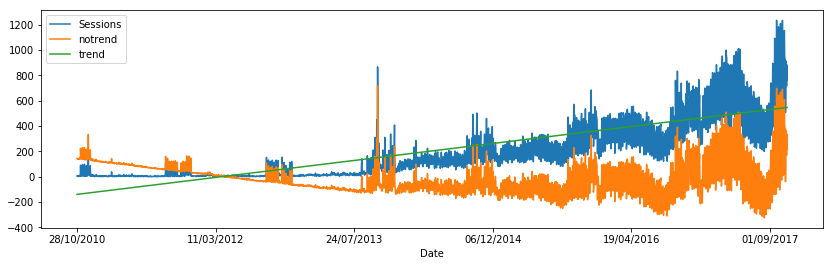

In [6]:
data.plot(y=["Sessions", "notrend", "trend"], figsize=(14,4))

On essaye de calculer une tendance en minimisant : $Y=\alpha + \beta t + \gamma t^2$.

c:\python36_x64\lib\site-packages\pandas\plotting\_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


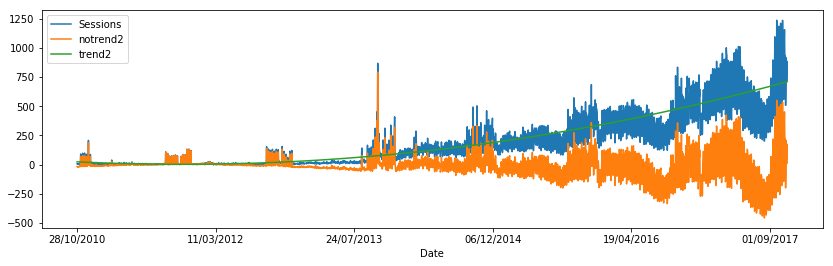

In [7]:
notrend2 = detrend(data['Sessions'], order=2)
data["notrend2"] = notrend2
data["trend2"] = data["Sessions"] - data["notrend2"]
data.plot(y=["Sessions", "notrend2", "trend2"], figsize=(14,4))

On passe au log.

c:\python36_x64\lib\site-packages\pandas\plotting\_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


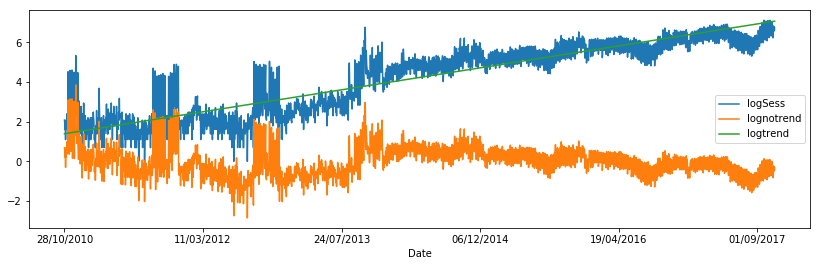

In [8]:
import numpy
data["logSess"] = data["Sessions"].apply(lambda x: numpy.log(x+1))
lognotrend = detrend(data['logSess'])
data["lognotrend"] = lognotrend
data["logtrend"] = data["logSess"] - data["lognotrend"]
data.plot(y=["logSess", "lognotrend", "logtrend"], figsize=(14,4))

La série est assez particulière. Elle donne l'impression d'avoir un changement de régime. On extrait la composante saisonnière avec [seasonal_decompose](http://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html#statsmodels.tsa.seasonal.seasonal_decompose).

c:\python36_x64\lib\site-packages\pandas\plotting\_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


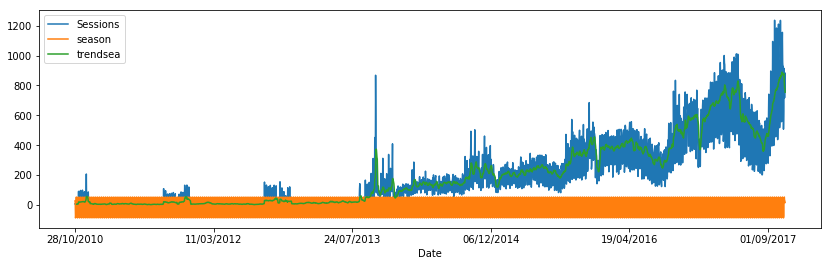

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(data["Sessions"].values.ravel(), freq=7, two_sided=False)
data["season"] = res.seasonal
data["trendsea"] = res.trend
data.plot(y=["Sessions", "season", "trendsea"], figsize=(14,4))

c:\python36_x64\lib\site-packages\pandas\plotting\_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


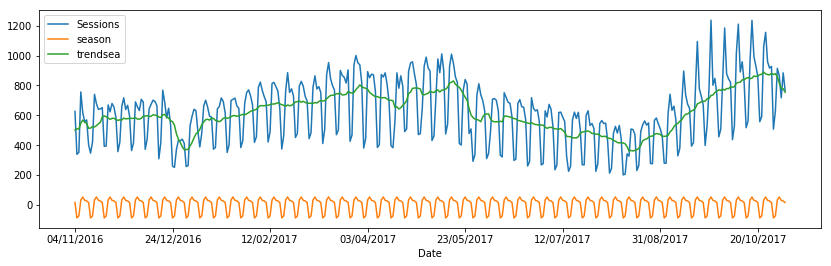

In [10]:
data[-365:].plot(y=["Sessions", "season", "trendsea"], figsize=(14,4))

c:\python36_x64\lib\site-packages\pandas\plotting\_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


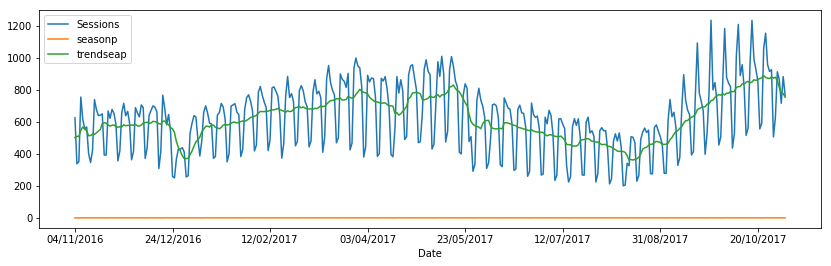

In [11]:
res = seasonal_decompose(data["Sessions"].values.ravel() + 1, freq=7, two_sided=False, model='multiplicative')
data["seasonp"] = res.seasonal
data["trendseap"] = res.trend
data[-365:].plot(y=["Sessions", "seasonp", "trendseap"], figsize=(14,4))

## Enlever la saisonnalité sans la connaître

Avec [fit_seasons](https://github.com/welch/seasonal/blob/master/seasonal/seasonal.py#L25).

[ 26.66213008  16.33420353 -86.59519495 -73.57497492  33.23110565
  52.87820674  30.87516435]


c:\python36_x64\lib\site-packages\pandas\plotting\_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


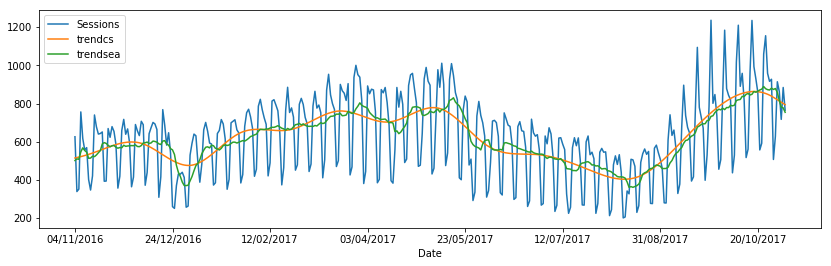

In [12]:
from seasonal import fit_seasons
cv_seasons, trend = fit_seasons(data["Sessions"])
print(cv_seasons)
# data["cs_seasons"] = cv_seasons
data["trendcs"] = trend
data[-365:].plot(y=["Sessions", "trendcs", "trendsea"], figsize=(14,4))

## Autocorrélograme

On s'inspire de l'exemple : [Autoregressive Moving Average (ARMA): Sunspots data](http://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html).

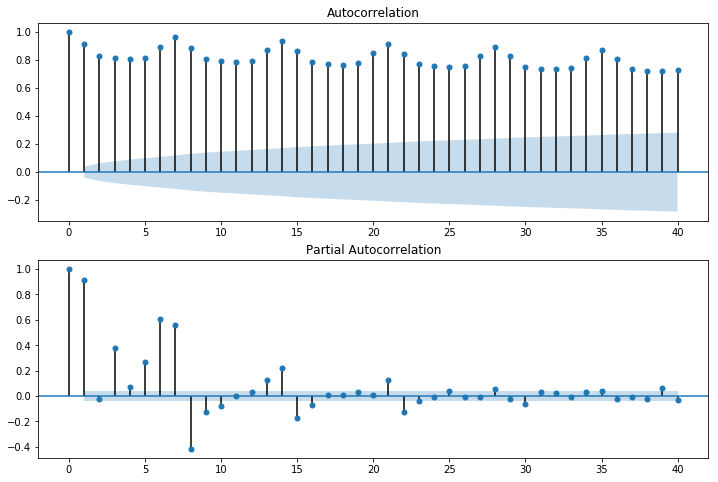

In [13]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(data["Sessions"], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(data["Sessions"], lags=40, ax=ax2)

On retrouve bien une période de 7.

In [14]:
from statsmodels.tsa.stattools import periodogram
p = periodogram(data["Sessions"])
p

array([        0.        ,  36864353.20831527,   7870812.5268101 , ...,
         4211956.47283695,   7870812.52681012,  36864353.20831531])

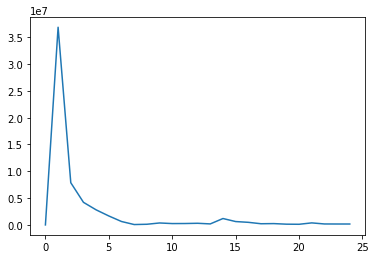

In [15]:
plt.plot(p[:25])

## Changements de régime

* [Gaussian HMM of stock data](https://hmmlearn.readthedocs.io/en/latest/auto_examples/plot_hmm_stock_analysis.html#sphx-glr-auto-examples-plot-hmm-stock-analysis-py)
* [MixedLM](http://www.statsmodels.org/dev/generated/statsmodels.regression.mixed_linear_model.MixedLM.html)
* [RLM](http://www.statsmodels.org/dev/examples/notebooks/generated/robust_models_0.html)
* [Local Linear Trend](http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_local_linear_trend.html)
* [MarkovAutoregression](http://www.statsmodels.org/dev/generated/statsmodels.tsa.regime_switching.markov_autoregression.MarkovAutoregression.html)